In [597]:
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [598]:
np.random.seed(32) # for deterministic results

# Medium Articles Dataset

We provide a dataset of medium articles which have to be tagged to corresponding topics (software-development, artificial intellignece, Ui/UX). Along with articles we have subscriptions lists. The articles may be related by common subscription lists. The goal is to exploit this naturally occuring network structure for classifying articles to topics. Hence, it is a 3-way node classification task

In [599]:
def read_data(dir_name: str, file_name: str):
    """Read the medium articles with lists

    Args:
        dir_name (str): Root directory of the medium title files and lists.

    Returns:
        final_data: merged dataframes with articles and lists
    """

    final_data = pd.read_csv(dir_name+"/"+file_name+".csv")
    return final_data

In [600]:
final_data = pd.read_csv("data/pipeline_assignment_data/full_data_without_labels.csv")
final_data

,article,title,subtitle,author,date,list
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,https://medium.com/@zemmali1990/list/aws-49f68...
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,https://medium.com/@TomaszCieplak/list/graph-d...
2,https://medium.com/@sarafparam/transformers-fo...,Transformers for Time-Series,Forecasting still remains to be dominated by S...,Param Saraf,2020-10-20,https://medium.com/@sergiobonato/list/time-ser...
3,https://medium.com/towards-data-science/review...,Reviewing A/B Testing Course by Google on Udacity,Read to find out how A/B tests are performed a...,Suyash Maheshwari,2020-05-10,https://medium.com/@online.rajib/list/ml-c2cac...
4,https://medium.com/towards-data-science/a-comp...,A Comprehensive Hands-on Guide to Transfer Lea...,Deep Learning on Steroids with the Power of Kn...,Dipanjan (DJ) Sarkar,2018-11-14,https://medium.com/@farhanhanavi07/list/deep-l...
...,...,...,...,...,...,...
27713,https://medium.com/cometheartbeat/deep-learnin...,Deep Learning Techniques you Should Know in 2022,"Over the years, Deep Learning has really taken...",Nisha Arya Ahmed,2022-04-21,https://medium.com/@vigguvenki/list/deep-learn...
27714,https://medium.com/towardsdev/intro-to-object-...,Intro to Object-Oriented Programming For Data ...,Implement a simple Linear Regression with OOP ...,Bex T.,2021-04-12,https://medium.com/@or.matalon2/list/oop-4aad5...
27715,https://medium.com/towards-data-science/learn-...,Learn Enough Docker to be Useful,Part 1: The Conceptual Landscape — Containers ...,Jeff Hale,2019-01-09,https://medium.com/@vaibhavb2473/list/machine-...
27716,https://medium.com/berndruecker/moving-from-em...,Moving from embedded to remote workflow engines,"For a long time, we have advocated for an arch...",Bernd Rücker,2022-02-08,https://medium.com/@giamma80/list/java-3c31810...


In [601]:
train = read_data("data/pipeline_assignment_data","train")

In [602]:
test = read_data("data/pipeline_assignment_data","test")
test

,index,article,title,subtitle,author,date,list,labels
0,2291,https://medium.com/towards-data-science/how-to...,How to Use the IBM Watson Tone Analyzer to Per...,How to use the IBM Watson Artificial Intellige...,Graham Harrison,2022-01-02,https://medium.com/@4ndres.gaviria/list/nlp-to...,artificial-intelligence
1,7292,https://medium.com/towards-data-science/surviv...,Survival Analysis: Intuition & Implementation ...,There is a statistical technique which can ans...,Anurag Pandey,2019-01-06,https://medium.com/@jz5246/list/analytics-559c...,artificial-intelligence
2,6768,https://medium.com/experience-stack/embrace-co...,Embrace Complexity (Part 1),Why all organisations should build internal ne...,Tony Seale,2022-02-04,https://medium.com/@yasha.brener/list/data-man...,software-development
3,15003,https://medium.com/towards-data-science/every-...,"Every Complex DataFrame Manipulation, Explaine...","Melts, pivots, joins, explodes, & more — Panda...",Andre Ye,2020-07-22,https://medium.com/@4ndres.gaviria/list/dataop...,artificial-intelligence
4,19782,https://medium.com/towards-data-science/macroe...,Macroeconomic & Financial Factors and Ordinary...,Econometrics model using Arbitrage Pricing The...,Sarit Maitra,2020-06-27,https://medium.com/@halo9pan/list/quantitative...,software-development
...,...,...,...,...,...,...,...,...
3945,14424,https://medium.com/towards-data-science/normal...,Normalization vs Standardization — Quantitativ...,Stop using StandardScaler from Sklearn as a de...,Shay Geller,2019-04-04,https://medium.com/@farhanhanavi07/list/applie...,artificial-intelligence
3946,18949,https://medium.com/@petruknisme/getting-starte...,Getting Started with Covenant C2 for Red Teaming,Command and Control is part of Red Teaming tac...,Aan,2021-11-21,https://medium.com/@jimmy.winghang/list/mitre-...,software-development
3947,9305,https://medium.com/towards-data-science/how-to...,How to Create a Vector-Based Movie Recommendat...,Building a movie recommendation system using t...,Michelangiolo Mazzeschi,2021-12-10,https://medium.com/@subhasis.jethy/list/recomm...,artificial-intelligence
3948,24337,https://medium.com/towards-data-science/how-to...,How to Use Pandas for Big Data,Run distributed workload with Pandas on Spark ...,Edwin Tan,2022-01-25,https://medium.com/@jethro_torczon/list/big-da...,artificial-intelligence


In [603]:
train["labels"].value_counts()

labels
software-development       11586
artificial-intelligence    10646
ux                           150
Name: count, dtype: int64

In [604]:
test["labels"].value_counts()

labels
software-development       2022
artificial-intelligence    1899
ux                           29
Name: count, dtype: int64

Note that the separated "train" and "test" data also contain an index column. The value in that index corresponds to the index of the row that article appears in the full data.

Note that some of the articles are repeated (when considering articles uniquely identified by their urls). Thus it might not be necessarily wise to use the index of an article itself as a unique identifier.

In [605]:
article_links = final_data["article"]
print(len(article_links))
print(len(set(article_links)))

27718
26660


## Label conversion

In [606]:
print(train["labels"])

0           software-development
1        artificial-intelligence
2        artificial-intelligence
3           software-development
4           software-development
                  ...           
22377    artificial-intelligence
22378       software-development
22379    artificial-intelligence
22380       software-development
22381       software-development
Name: labels, Length: 22382, dtype: object


In [607]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
"""Generate encoding for labels using label encoder"""
multilabel_binarizer = LabelEncoder()
multilabel_binarizer.fit(train["labels"]) 

Y = multilabel_binarizer.transform(train["labels"]) 
texts = [x[0]+" " + x[1] for x in zip(train.title,train.subtitle)]

Notice that the 3 labels have been converted into a numerical value:

In [608]:
print(f'The labels: {list(multilabel_binarizer.classes_)} have been respectively assigned the values: {set(Y)}')
print(f'The label of the first article is: {train["labels"][0]} and was assigned label index: {Y[0]}')

The labels: ['artificial-intelligence', 'software-development', 'ux'] have been respectively assigned the values: {0, 1, 2}
The label of the first article is: software-development and was assigned label index: 1


# Basic Word2Vec model prediction

We will train the model on the corpus composed of a list of a list of the words per article title + subtitle pair.

In [609]:
all_texts = [x[0]+ " " + x[1] for x in zip(final_data.title,final_data.subtitle)]
print(all_texts[0])
print()
all_texts_split = [text.split(" ") for text in all_texts]
print(all_texts_split[0])
print()

unique_values_set = set()
for sublist in all_texts_split:
    for value in sublist:
        unique_values_set.add(value)

print(f'We will train on {len(all_texts_split)} article descriptions, with {sum([len(v) for v in all_texts_split])} words in total, with {len(unique_values_set)} unique entries.')

Code/Demo Share: Palo Alto Firewall Network Infrastructure Automation with Consul-Terraform-Sync IP is broken as a unit of Control! IDENTITY as a unit of control is the key to succeed in discovering, securing and automating your current workflows across any runtime and cloud. Let’s discuss how we can automate Palo Alto Network firewall dynamic address groups using Consul with Terraform. The…

['Code/Demo', 'Share:', 'Palo', 'Alto', 'Firewall', 'Network', 'Infrastructure', 'Automation', 'with', 'Consul-Terraform-Sync', 'IP', 'is', 'broken', 'as', 'a', 'unit', 'of', 'Control!', 'IDENTITY', 'as', 'a', 'unit', 'of', 'control', 'is', 'the', 'key', 'to', 'succeed', 'in', 'discovering,', 'securing', 'and', 'automating', 'your', 'current', 'workflows', 'across', 'any', 'runtime', 'and', 'cloud.', 'Let’s', 'discuss', 'how', 'we', 'can', 'automate', 'Palo', 'Alto', 'Network', 'firewall', 'dynamic', 'address', 'groups', 'using', 'Consul', 'with', 'Terraform.', 'The…']

We will train on 27718 arti

In [610]:
from gensim.models import Word2Vec
"""Train word2vec model on title + subtitles to establish a baseline without network structure"""
word2vec_model = Word2Vec(all_texts_split, vector_size=128, window=10, epochs=30, sg=1, workers=4,min_count=1)

Sample usage of the model:

In [611]:
np.set_printoptions(threshold=10)
print(f'The embedding for the word "Spring" is {word2vec_model.wv["Spring"]}, with shape: {word2vec_model.wv["Spring"].shape}')

# Running the model on an unseen word will raise an error!

The embedding for the word "Spring" is [ 0.2478444   0.42374316  1.0035605  ...  0.09313499 -0.00458524
 -0.29538107], with shape: (128,)


In [612]:
from sklearn.svm import SVC
embeddings = []
"""Infer word2vec embeddings for article titles and subtitles using trained word2vec model"""
for text in texts:
    # Each text is one article (title + subtitle)
    embeddings.append(
        np.mean(
            [word2vec_model.wv[word] for word in text.split(" ")] # At this point, we will have an array of size (n, 128) where n is the number of words in the title + subtitle
            , axis=0 # We compress each column, thus we obtain an array of size (1,128) which represents the embedding of each article (text)
        ) # We add the embedding to our list
    )

X_word2vec = np.vstack(embeddings)
print(f'The shape {X_word2vec.shape} corresponds to the 128 parameter long encoding of each article.')
print(f'This corresponds to Y array with {Y.shape} entries, containing the labels for each article.')

The shape (22382, 128) corresponds to the 128 parameter long encoding of each article.
This corresponds to Y array with (22382,) entries, containing the labels for each article.


In [613]:
"""Train a SVM classifier on generated article embeddings"""
svc = SVC()
svc.fit(X_word2vec,Y)

SVC()

In [614]:
test_embeddings = []
test_texts = [x[0]+ " " + x[1] for x in zip(test.title,test.subtitle)]
"""Compute embeddings for test samples"""
for text in test_texts:
    test_embeddings.append(np.mean([word2vec_model.wv[word] for word in text.split(" ")], axis=0))
X_word2vec_test = np.vstack(test_embeddings)
print(f'The shape {X_word2vec_test.shape} corresponds to the 128 parameter long encoding of each article in the test data.')

The shape (3950, 128) corresponds to the 128 parameter long encoding of each article in the test data.


In [615]:
"""Generate predictions using the SVM classifier for test articles"""
predictions = svc.predict(X_word2vec_test)

In [616]:
"""Encode reference labels"""
Y_test = multilabel_binarizer.transform(test["labels"])

Add this point we have a first attempt at predicting the label for articles in our test set, without using the list information at all, rather just analyzing the embeddings of each article's description. We can see that both the predicted and Y_test have the same number of elements (as a sanity check - we are testing on 3950 articles). 

However, we can already spot that we have not predicted any articles having the "UX" label. Granted, these were only 29 out of 3950, or 0.73%, with a similarly low percentage in the training data (0.67%).

In [617]:
print(predictions.shape)
print(set(predictions))
print(Y_test.shape)
print(set(Y_test))

(3950,)
{0, 1}
(3950,)
{0, 1, 2}


In [618]:
from sklearn import metrics
"""Compute Macro f1"""
print(metrics.f1_score(Y_test, predictions,average="macro"))

0.5515655282059746


In [619]:
print(metrics.classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1899
           1       0.84      0.81      0.83      2022
           2       0.00      0.00      0.00        29

    accuracy                           0.82      3950
   macro avg       0.55      0.55      0.55      3950
weighted avg       0.82      0.82      0.82      3950


C:\CodingProjects\Graph-embedings\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\CodingProjects\Graph-embedings\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\CodingProjects\Graph-embedings\venv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

We can see that because of the low proportion of "UX" articles, we get a low f1-score. However, the weighted average suggests a precision of around 82%.

# Graph embeddings - Pipeline Overview 

Our goal is to construct a graph from the given data by connecting nodes that at least share one common subscription list.

This step is followed by a random walk to construct node embeddings.

Then the node embeddings are employed for the task of topic classification.

## Forming the graph - monopartite projection

Our goal is to construct a graph from  given data by connecting nodes that at least share one common subscription list.

In [620]:
from typing import List,Dict

def get_nodes_url(data: pd.DataFrame) -> Dict:
    """ Given the dataframe with articles and lists return the set of nodes
        Args:
        data (pd.DataFrame): The medium dataset
    Returns:
        nodes: dict maps a url to its main id"""
    nodes = {}
    url_to_node = {}
    for index, row in data.iterrows():
        if row["article"] not in url_to_node:
            nodes[index] = [row["article"]]
            url_to_node[row["article"]] = index
        else:
            # add alternative id
            nodes[url_to_node[row["article"]]].append(index)
    return url_to_node

In [621]:
def get_edges(data: pd.DataFrame, nodes: Dict) -> List:
    """ Given the dataframe with articles and lists return the set of edges
        Args:
        data (pd.DataFrame): The medium dataset
        nodes: dict (nodeId: article title)
    Returns:
        edges (List[tuple]): List of edges"""
    edges = set()
    ## START
    
    # dictionary to get main id from article url
    url_to_mainId = get_nodes_url(data)
    
    # for each list, we will store all the articles that are part of it, then we will create edges between each of the paris of articles part of the same list
    lists = {} 
    for index, row in data.iterrows():
        if index in nodes:
            mainId = index
        else:
            # index is an alternative id
            mainId = url_to_mainId[row["article"]]
        
        # since some articles are part of multiple lists we will assign them to each
        urls = row["list"].split('; ')
        for url in urls:
            if url in lists:
                lists[url].append(mainId)
            else:
                lists[url] = [mainId]
    for list_values in lists.values():
        n = len(list_values)
        for i in range(0, n):
            for j in range(i+1, n):
                edges.add((list_values[i], list_values[j]))
    ##END
    return list(edges)

In [622]:
def get_nodes(data: pd.DataFrame) -> Dict:
    """ Given the dataframe with articles and lists return the set of nodes
        Args:
        data (pd.DataFrame): The medium dataset
    Returns:
        nodes: dict maps a main id to its url (first element in the value list), then alternative ids (defined below)"""
    nodes = {}
    url_to_node = {}
    for index, row in data.iterrows():
        if row["article"] not in url_to_node:
            nodes[index] = [row["article"]]
            url_to_node[row["article"]] = index
        else:
            # add alternative id
            nodes[url_to_node[row["article"]]].append(index)
    return nodes

Note that, as per our earlier discussion, the article urls are not unique in the full data. Thus, we will modify the get_nodes to reflect this fact. We will use the row index of the first appearance of a url to be the main id. Then, in order to capture eventual repeating values, we will also store the other indexes (alternative ids) of the same article as a list in the returned dictionary. Notice that the urls are also unique in the returned dictionary, linked 1 to 1 to the main id.

For example: 0 -> \["url", 1, 2] means that the article uniquely identified by the "url" has the main id 0 (row where it first appear), and alternative ids 1 and 2.

In [623]:
nodes = get_nodes(final_data)

train_url_set = set(train["article"])
train_test_set = set(test["article"])

count_alternative_ids = 0
max_count = 0
example_value = ()

duplicated_count_labeled = 0

for key, value in nodes.items():
    if len(value) > 1:
        if value[0] in train_url_set or value[0] in train_test_set:
            duplicated_count_labeled+=1
        example_value = (key, value)
        count_alternative_ids+=1
        max_count = max(max_count, len(value))
print(count_alternative_ids)
print(max_count)
print(example_value)

print(duplicated_count_labeled)

1058
2
(26685, ['https://medium.com/@maniakacademy/automating-application-delivery-with-consul-nia-part-1-f5-big-ip-b5e30138be5c', 26875])
1054


Running our code, we can see that for 1058 unique articles, their url appeared more than once (in fact, twice) in the full data. For each of these cases, we have also stored the alternative id. Moreover, 1054 out of the 1058 articles also appear in our labeled data, so our (complex) pre-processing can be justified.

In [624]:
import networkx as nx
def form_graph(data: pd.DataFrame) -> nx.Graph:
    """Forms graph from medium article dataset.

    Args:
        data (pd.DataFrame): The medium dataset

    Returns:
        G (nx.Graph): The graph.

       """
    # texts = [x[0]+" " + x[1] for x in zip(data.title,data.subtitle)]
    nodes = get_nodes(data)
    edges = get_edges(data, nodes)
    graph = nx.Graph()
    graph.add_nodes_from(list(nodes.keys()))
    graph.add_edges_from(edges)
    return graph


In [625]:
graph = form_graph(final_data)


Now that we have created the graph (might take a minute), we can run some analysis on it:

In [626]:
print(f'Number of nodes: {graph.number_of_nodes()}. This corresponds to the number of rows in the final data ({len(final_data)}) - the number of rows which refer to the same article url ({count_alternative_ids} -> computed earlier).\n')
print(f'Number of edges: {graph.number_of_edges()}\n')
print(f'As a measure of the sparseness of the adjacency matrix, we can check how many edges we have, with respect to how many pairs of nodes exist: {graph.number_of_edges() / (graph.number_of_nodes() ** 2)}, or around {graph.number_of_edges() / (graph.number_of_nodes() ** 2) * 100}%.')


Number of nodes: 26660. This corresponds to the number of rows in the final data (27718) - the number of rows which refer to the same article url (1058 -> computed earlier).

Number of edges: 1711216

As a measure of the sparseness of the adjacency matrix, we can check how many edges we have, with respect to how many pairs of nodes exist: 0.002407601150099978, or around 0.2407601150099978%.


# Node2Vec

Here the task is to perform random walks on the graph formed in the previous step and compute embeddings for the nodes using the random walk results.

We will use gensim - Word2Vec to compute embeddings, but implement random walks manually, using our weblab implementation.

In [627]:
# Find isolated nodes with no neighbors before random walks
### START
isolated = []
for node in graph:
    if graph.degree(node) == 0:
        isolated.append(node)
print(f'We have {len(isolated)} isolated nodes.')
### END

We have 347 isolated nodes.


In [628]:
import random
def random_walks(G: nx.Graph, num_walks: int, walk_length: int, isolated: List) -> np.ndarray:
    """Perform random walks on the graph.

    Args:
        G (nx.Graph): The graph.
        num_walks (int): The number of random walks for each node.
        walk_length (int): The number of nodes in a random walk.
        isolated (List[int]): list of isolated nodeids

    Returns:
        np.ndarray: The random walks, shape (n_nodes * num_walks, walk_length)
    """
    result = []
    isolated_set = set(isolated)
    ### START
    for node in sorted(G):
        if node in isolated_set:
            continue
        for walk in range(num_walks):
            walk_result = []
            cur_node = node
            for step in range(walk_length):
                walk_result.append(cur_node)
                list_neighbors = list(G[cur_node].keys())
                cur_node = random.choice(list_neighbors)
            result.append(walk_result)
    ## END
    return np.asarray(result)

In [629]:
walks = random_walks(graph, 8, 15,isolated)

In [630]:
from gensim.models import Word2Vec
def fit_node2vec(walks: np.ndarray, vector_size: int, window: int, epochs: int) -> Word2Vec:
    """Train a Node2Vec model on random walks. Uses the GenSim Word2Vec implementation.

    Args:
        walks (np.ndarray): The random walks.
        vector_size (int): Node representation size.
        window (int): Window width.
        epochs (int): Number of epochs.

    Returns:
        Word2Vec: The trained model.
    """
    # in order to speed up the computation of the model, each node id will be converted to a string, as gensim runs faster on strings
    aux = [[str(x) for x in y] for y in walks]
    return Word2Vec(sentences=aux, window=window, vector_size=vector_size, epochs = epochs)

In [631]:
def get_nodeids(data: pd.DataFrame):
    """Get nodeids from graph

    Args:
        data (pd.DataFrame): medium articles dataset

    Returns:
        nodes (dict): mainIds
    """
    nodeset = set()
    for index, row in data.iterrows():
        if row["index"] in nodes:
            nodeset.add(row["index"])
    return sorted(list(nodeset))

In [632]:
"""Get train and test nodes from the graph"""
train_nodes = get_nodeids(train)
test_nodes = get_nodeids(test)

In [633]:
print(len(train_nodes))

21531


## Label preprocessing
In order to account for our usage of "main" and "additional" ids, we will process the label data, such that its length and order will fit with our new data.

In [634]:
Y_processed = []
for index, row in train.sort_values(by=['index']).iterrows():
    if row["index"] in nodes:
        Y_processed.append(row["labels"])
Y_processed = multilabel_binarizer.transform(Y_processed) 

Y_test_processed = []
for index, row in test.sort_values(by=['index']).iterrows():
    if row["index"] in nodes:
        Y_test_processed.append(row["labels"])
Y_test_processed = multilabel_binarizer.transform(Y_test_processed) 

# Node2vec predictions

Now, we will return to the model that we will proceed to train. We will use the embeddings to create a dictionary which maps a nodeId to its embedding. Then, using that we will create embeddings for the entire train and test dataset, which we will then be used to train a Support Vector Machine in order to make predictions from labels. Before doing this, however, we would like to test a few of our choices for the hyperparameters of our node2vec settings for training the model. We will test the accuracy of the model after different number of epochs, to test if it actually improves with more iterations over the dataset.

In [635]:
def node2vec_predict(localModel, num):
    node2vec_embeddings = {word: localModel.wv[word] for word in localModel.wv.index_to_key}

    # Note that isolated nodes are embedded as an array of zeroes, since they don't contain any network-related data
    X_train_n2v = np.array([node2vec_embeddings[str(x)] if x not in isolated else np.zeros(128) for idx, x in enumerate(train_nodes)], dtype=np.float32)
    X_test_n2v = np.array([node2vec_embeddings[str(x)] if x not in isolated else np.zeros(128) for idx, x in enumerate(test_nodes)], dtype=np.float32)
    svc = SVC()
    svc.fit(X_train_n2v,Y_processed)
    predictions = svc.predict(X_test_n2v)
    if num==2:
        print(metrics.classification_report(Y_test_processed, predictions))
    print(metrics.accuracy_score(Y_test_processed,predictions))

In [636]:
#testing the accuracies if we give the model 1, 5, and 10 epochs respectively.

model = fit_node2vec(walks, 128, 5, 1)
node2vec_predict(model,1)
model = fit_node2vec(walks, 128, 5, 5)
node2vec_predict(model,1)
model = fit_node2vec(walks, 128, 5, 10)
node2vec_predict(model,2)

0.6122073138647725
0.7879505393317549
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1794
           1       0.85      0.74      0.79      1978
           2       0.86      0.41      0.56        29

    accuracy                           0.80      3801
   macro avg       0.82      0.67      0.72      3801
weighted avg       0.80      0.80      0.79      3801

0.7950539331754801


Now that we have shown that 5 epochs seem to be a valid choice, given that the difference in accuracy between 5 and 10 epochs is less than 0.008, we will proceed with our choice of 5 epochs.

# Word2vec + Node2vec predictions

Finally, we can also use the previously computed embeddings for article titles to improve our model. 

In [637]:
"""Compute train and test embeddings.
Concatenate the word2vec embeddings of article titles
with the node2vec embeddings using the dictionary from previous step.
Dimension 1 of your embeddings should be 256.
 Consider isolated nodes and handle them when computing embeddings"""



id_to_title_embedding = []
"""Infer word2vec embeddings for article titles and subtitles using trained word2vec model"""
for index, row in final_data.iterrows():
    text = row["title"] + " " + row["subtitle"]
    # Each text is one article (title + subtitle)
    id_to_title_embedding.append(
        np.mean(
            [word2vec_model.wv[word] for word in text.split(" ")] # At this point, we will have an array of size (n, 128) where n is the number of words in the title + subtitle
            , axis=0 # We compress each column, thus we obtain an array of size (1,128) which represents the embedding of each article (text)
        ) # We add the embedding to our list
    )

"""Compute train and test embeddings.
Concatenate the word2vec embeddings of article titles
with the node2vec embeddings using the dictionary from previous step.
Dimension 1 of your embeddings should be 256.
 Consider isolated nodes and handle them when computing embeddings"""
node2vec_embeddings = {word: model.wv[word] for word in model.wv.index_to_key}

X_train_n2v_w2v =  np.array(
    [ np.concatenate([id_to_title_embedding[x],node2vec_embeddings[str(x)]]) 
      if x not in isolated 
      else np.concatenate([id_to_title_embedding[x],np.zeros((128))])  
      for idx, x in enumerate(train_nodes)  
      ], dtype=np.float32)

X_test_n2v_w2v = np.array(
    [ np.concatenate([id_to_title_embedding[x],node2vec_embeddings[str(x)]]) 
      if x not in isolated 
      else np.concatenate([id_to_title_embedding[x],np.zeros((128))])  
      for idx, x in enumerate(test_nodes)  
      ], dtype=np.float32)

In [638]:
X_train_n2v_w2v.shape,X_test_n2v_w2v.shape

((21531, 256), (3801, 256))

In [639]:
svc = SVC()
svc.fit(X_train_n2v_w2v,Y_processed)
predictions = svc.predict(X_test_n2v_w2v)
print(metrics.classification_report(Y_test_processed, predictions))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1794
           1       0.86      0.79      0.82      1978
           2       0.86      0.41      0.56        29

    accuracy                           0.82      3801
   macro avg       0.84      0.69      0.74      3801
weighted avg       0.83      0.82      0.82      3801


We will now plot the tsne plots of the embeddings in order to show the difference between the two approaches. Based on intuition, we expected that the word2vec+node2vec settings will perform better than the settings only using node2vec features, because the first former uses more data to compute the embeddings, and should logically be more accurate. Our expectations are also validated by the accuracies listed above: while the node2vec reached ~79% accuracy, the node2vec+word2vec settings reached almost 83% accuracy.

In [640]:
# Apply t-SNE transformation to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
X_train_n2v = np.array([node2vec_embeddings[str(x)] if x not in isolated else np.zeros(128) for idx, x in enumerate(train_nodes)], dtype=np.float32)
node_embeddings_2d = tsne.fit_transform(X_train_n2v)
node_embeddings_2d_both = tsne.fit_transform(X_train_n2v_w2v)

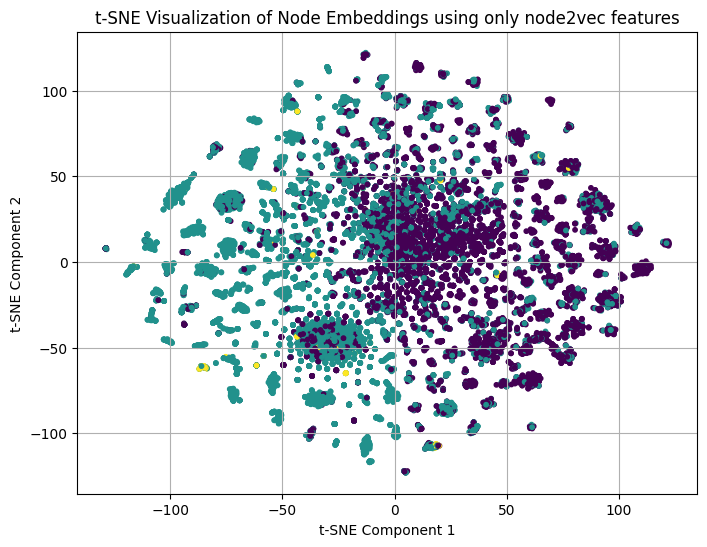

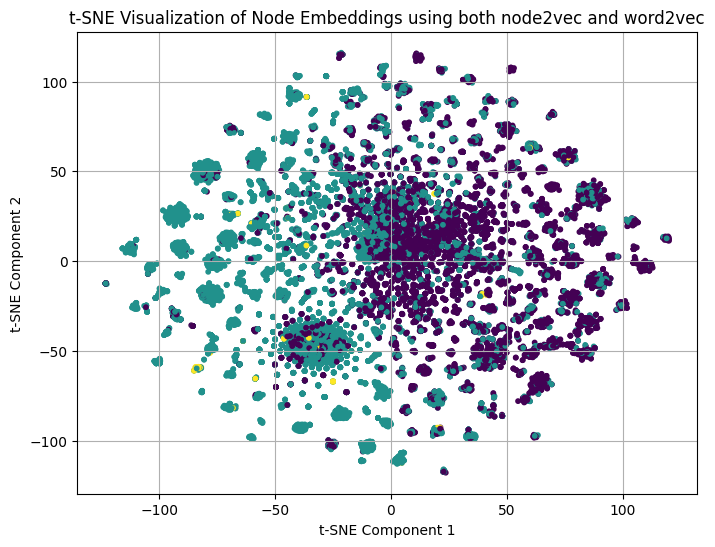

In [642]:
# Scatter plot of the 2D embeddings with color based on labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=Y_processed,
    cmap='viridis',  # You can choose a different colormap
    marker='o',
    s=10
)
plt.title('t-SNE Visualization of Node Embeddings using only node2vec features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

# Scatter plot of the 2D embeddings with color based on labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    node_embeddings_2d_both[:, 0],
    node_embeddings_2d_both[:, 1],
    c=Y_processed,
    cmap='viridis',  # You can choose a different colormap
    marker='o',
    s=10
)
plt.title('t-SNE Visualization of Node Embeddings using both node2vec and word2vec')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

While the plots do not show a massive difference, the small difference in accuracy between the 2 approaches seems to justify this result. It can still be observed that the two most frequent labels are a bit more clearly separated in the second plot, showing that the node2vec + word2vec settings do lead to a better result, as expected.